In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import theano.tensor as T
import pymc3 as pm
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

Text(0, 0.5, 'logistic(z)')

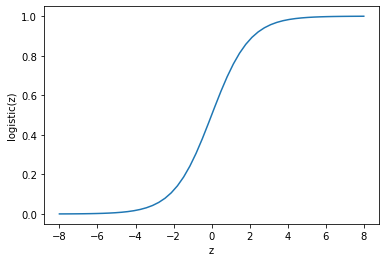

In [2]:
z = np.linspace(-8, 8)
plt.plot(z, 1 / (1 + np.exp(-z)))
plt.xlabel('z')
plt.ylabel('logistic(z)')

In [18]:
iris = pd.read_csv('../data/iris.csv')
iris.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

<AxesSubplot:xlabel='species', ylabel='sepal_length'>

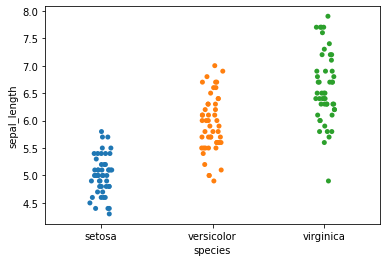

In [4]:
sns.stripplot(x = "species", 
             y = "sepal_length", 
             data = iris,
             jitter = True)

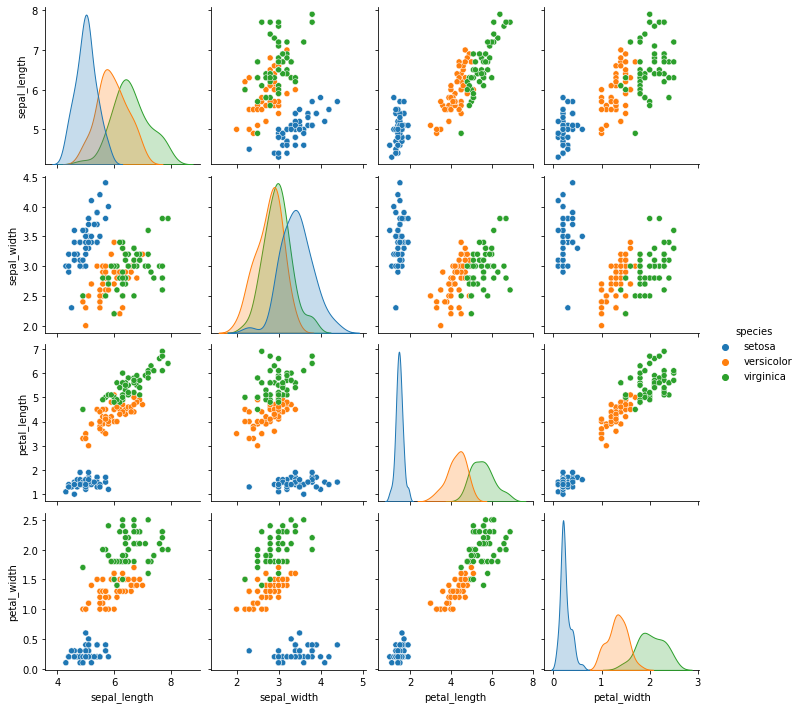

In [5]:
sns.pairplot(iris, hue = 'species', diag_kind = 'kde')

# Simple logistic model of iris

In [6]:
df = iris.query("species == ('setosa', 'versicolor')") # like filter?
y_0 = pd.Categorical(df['species']).codes #make it 0/1 integer.
x_n = 'sepal_length' #just this character
x_0 = df[x_n].values #queries for values in this column. 
x_c = x_0 - x_0.mean() #centered. 

In [7]:
# the model
with pm.Model() as model_0:
    α = pm.Normal('α', mu = 0, sd = 10)
    β = pm.Normal('β', mu = 0, sd = 10)
    μ = α + pm.math.dot(x_c, β) 
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ)) #sigmoid of mu. 
    bd = pm.Deterministic('bd', -α/β) #criterion
    yl = pm.Bernoulli('yl', p = θ, observed = y_0)
    
    # trace
    trace_0 = pm.sample(1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'θ'}>,
        <AxesSubplot:title={'center':'θ'}>],
       [<AxesSubplot:title={'center':'bd'}>,
        <AxesSubplot:title={'center':'bd'}>]], dtype=object)

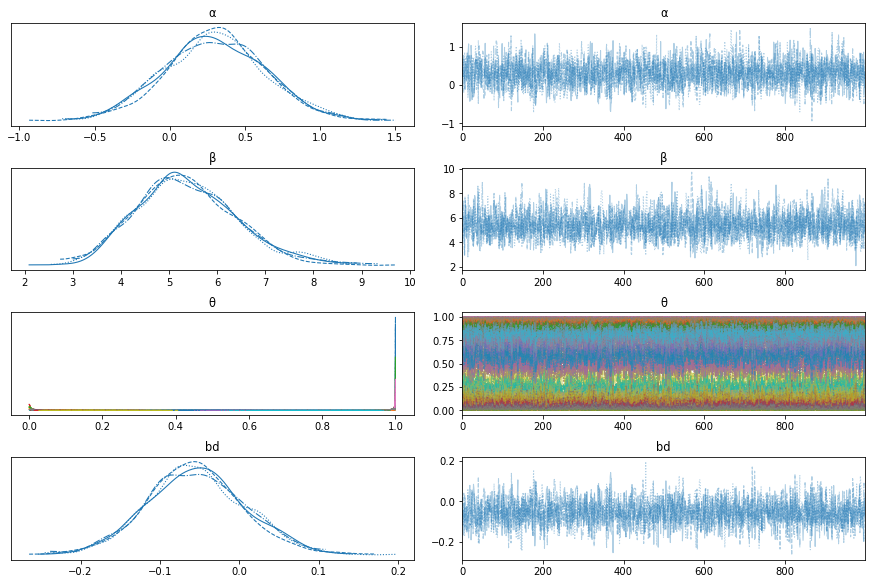

In [8]:
az.plot_trace(trace_0)

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\stats\stats.py:340: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(


([<matplotlib.axis.XTick at 0x29b14e06760>,
 [Text(-1.5, 0, '4.0'),
  Text(-1.0, 0, '4.5'),
  Text(-0.5, 0, '5.0'),
  Text(0.0, 0, '5.5'),
  Text(0.5, 0, '6.0'),
  Text(1.0, 0, '6.5'),
  Text(1.5, 0, '7.0'),
  Text(2.0, 0, '7.5')])

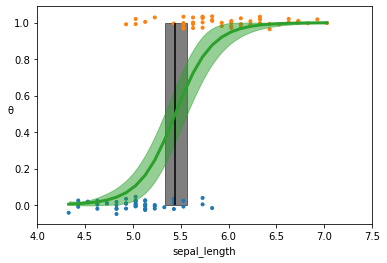

In [9]:
theta = trace_0['θ'].mean(axis = 0)
idx = np.argsort(x_c)
plt.plot(x_c[idx], theta[idx], color = 'C2', lw = 3) 
plt.vlines(trace_0['bd'].mean(), 0, 1, color = 'k')
bd_hpd = az.hpd(trace_0['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color = 'k', alpha = 0.5)

plt.scatter(x_c, np.random.normal(y_0, 0.02),
           marker = '.', color = [f'C{x}' for x in y_0])
az.plot_hpd(x_c, trace_0['θ'], color = 'C2')

plt.xlabel(x_n)
plt.ylabel('θ', rotation = 0)

# original scale for xticks
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1))

# Multiple logistic regression

In [19]:
df = iris.query("species == ('setosa', 'versicolor')")
y_1 = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width']
x_1 = df[x_n].values

In [14]:
# model
with pm.Model() as model_1:
    α = pm.Normal('α', mu = 0, sd = 10)
    β = pm.Normal('β', mu = 0, sd = 2, shape = len(x_n)) #length 2. 
    μ = α + pm.math.dot(x_1, β)
    θ = pm.Deterministic('θ', 1 / (1 + pm.math.exp(-μ)))
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_1[:, 0])
    yl = pm.Bernoulli('yl', p = θ, observed = y_1)
    
    trace_1 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 58 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Text(0, 0.5, 'sepal_width')

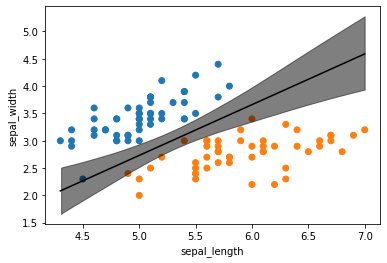

In [28]:
# plot
idx = np.argsort(x_1[:, 0])
bd = trace_1['bd'].mean(0)[idx]
plt.scatter(x_1[:, 0], x_1[:, 1], c = [f'C{x}' for x in y_0])
plt.plot(x_1[:, 0][idx], bd, color = 'k')

az.plot_hpd(x_1[:, 0], trace_1['bd'], color = 'k')

plt.xlabel(x_n[0])
plt.ylabel(x_n[1])

# Interpreting coef. of log. reg. 

<ipython-input-29-384f637e8225>:3: RuntimeWarning: divide by zero encountered in true_divide
  odds = probability / (1 - probability)


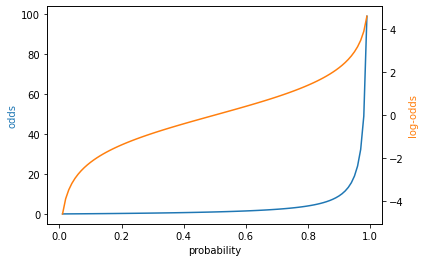

In [29]:
# probabilities, odds, log-odds
probability = np.linspace(0.01, 1, 100)
odds = probability / (1 - probability)

_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(probability, odds, 'C0')
ax2.plot(probability, np.log(odds), 'C1')

ax1.set_xlabel('probability')
ax1.set_ylabel('odds', color = 'C0')
ax2.set_ylabel('log-odds', color = 'C1')
ax1.grid(False)
ax2.grid(False)

In [33]:
# summary values in log-odds scale
df = az.summary(trace_1, var_names = ['α', 'β'])
df

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
α    -9.319  4.665 -17.961   -0.569      0.098    0.069    2268.0  2267.0   
β[0]  4.728  0.873   3.078    6.292      0.020    0.014    1896.0  1896.0   
β[1] -5.226  0.982  -6.959   -3.339      0.021    0.015    2160.0  2160.0   

      ess_bulk  ess_tail  r_hat  
α       2271.0    2451.0    1.0  
β[0]    1858.0    1509.0    1.0  
β[1]    2075.0    1440.0    1.0

In [46]:
# could not find the logistic function..
import math
def logistic(logodd):
    return(1 + 1 / math.exp(-logodd))

In [51]:
x_1 = 4.5 #sepal_length
x_2 = 3 # sepal_width

log_odds_versicolor_i = (df['mean'] * [1, x_1, x_2]).sum()
probability_versicolor_i = logistic(log_odds_versicolor_i)

log_odds_versicolor_f = (df['mean'] * [1, x_1 + 1, x_2]).sum()
probability_versicolor_f = logistic(log_odds_versicolor_f)

beta0 = log_odds_versicolor_f - log_odds_versicolor_i
beta1 = probability_versicolor_f - probability_versicolor_i

print(f'beta_0 = {beta0}\nsomething else? = {beta1}')

beta_0 = 4.727999999999996
something else? = 2.7131668088396825


# Dealing with correlated var.

<AxesSubplot:>

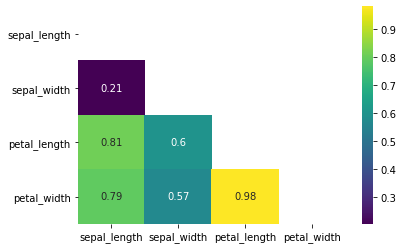

In [52]:
corr = iris[iris['species'] != 'virginica'].corr()
mask = np.tri(*corr.shape).T
sns.heatmap(corr.abs(), mask = mask, annot = True, cmap = 'viridis')

In [53]:
# more information in priors - or throw away extremely correlated var. 
# balancing classes


In [54]:
df = iris.query("species == ('setosa', 'versicolor')")
df = df[45:] #remove the first 45 obs. 
y_3 = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width']
x_3 = df[x_n].values

In [55]:
# run model
with pm.Model() as model_3:
    α = pm.Normal('α', mu = 0, sd = 10)
    β = pm.Normal('β', mu = 0, sd = 2, shape = len(x_n))
    μ = α + pm.math.dot(x_3, β)
    θ = 1 / (1 + pm.math.exp(-μ))
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * x_3[:, 0])
    yl = pm.Bernoulli('yl', p = θ, observed = y_3)
    
    trace_3 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6772553867060733, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


Text(0, 0.5, 'sepal_width')

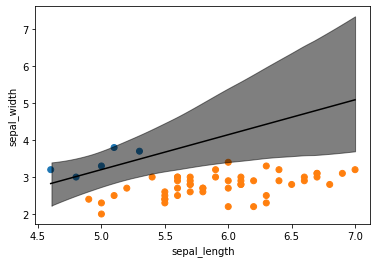

In [57]:
# plotting:
# with less data (in one group) the boundary moves closer to this group.
idx = np.argsort(x_3[:, 0])
bd = trace_3['bd'].mean(0)[idx]
plt.scatter(x_3[:, 0], x_3[:, 1], c = [f'C{x}' for x in y_3])
plt.plot(x_3[:, 0][idx], bd, color = 'k')

# uncertainty interval
az.plot_hpd(x_3[:, 0], trace_3['bd'], color = 'k')

plt.xlabel(x_n[0])
plt.ylabel(x_n[1])

# Softmax regression
one way to generalize logistic reg. to more than two classes.

In [58]:
iris = sns.load_dataset('iris')
y_s = pd.Categorical(iris['species']).codes
x_n = iris.columns[:-1] 
x_s = iris[x_n].values
x_s = (x_s - x_s.mean(axis = 0)) / x_s.std(axis = 0)

In [59]:
import theano.tensor as tt

In [63]:
with pm.Model() as model_s: 
    α = pm.Normal('α', mu = 0, sd = 5, shape = 3) #three classes
    β = pm.Normal('β', mu = 0, sd = 5, shape = (4, 3)) #four predictors
    μ = pm.Deterministic('μ', α + pm.math.dot(x_s, β))
    θ = tt.nnet.softmax(μ)
    yl = pm.Categorical('yl', p = θ, observed = y_s)
    
    trace_s = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 104 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


In [65]:
# how well did it predict? (.98)
data_pred = trace_s['μ'].mean(0)
y_pred = [np.exp(point)/np.sum(np.exp(point), axis = 0) for point in data_pred]
f'{np.sum(y_s == np.argmax(y_pred, axis = 1)) / len(y_s):.2f}'

'0.98'

In [67]:
# model where we set some parameters to 0
with pm.Model() as model_sf:
    α = pm.Normal('α', mu = 0, sd = 2, shape = 2)
    β = pm.Normal('β', mu = 0, sd = 2, shape = (4, 2))
    α_f = tt.concatenate([[0], α])
    β_f = tt.concatenate([np.zeros((4, 1)), β], axis = 1)
    μ = α_f + pm.math.dot(x_s, β_f)
    θ = tt.nnet.softmax(μ)
    yl = pm.Categorical('yl', p = θ, observed = y_s)
    
    #trace
    trace_sf = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 68 seconds.


In [70]:
soft1 = az.summary(trace_s, var_names = ['α', 'β']) #high sd.
soft2 = az.summary(trace_sf, var_names = ['α', 'β']) #low sd. 

# discriminative & generative

In [73]:
## implementing a generative classifier (LDA). 
with pm.Model() as lda:
    μ = pm.Normal('μ', mu = 0, sd = 10, shape = 2) #2 classes
    σ = pm.HalfNormal('σ', 10)
    setosa = pm.Normal('setosa', mu = μ[0], sd = σ,
                      observed = x_0[:50])
    versicolor = pm.Normal('versicolor', mu = μ[1],
                          sd = σ, observed = x_0[50:])
    bd = pm.Deterministic('bd', (μ[0] + μ[1]) / 2)
    trace_lda = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


Text(0.5, 0, 'sepal_length')

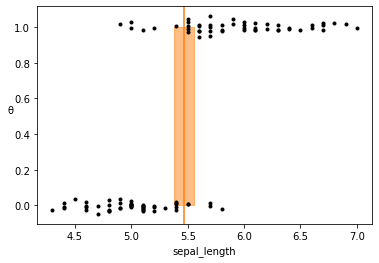

In [76]:
## plot two classes agains HPD
plt.axvline(trace_lda['bd'].mean(), ymax = 1, color = 'C1')
bd_hpd = az.hpd(trace_lda['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color = 'C1', alpha = 0.5)

plt.plot(x_0, np.random.normal(y_0, 0.02), '.', color = 'k')
plt.ylabel('θ', rotation = 0)
plt.xlabel('sepal_length')

# Poisson regression
for count data.

number of events in fixed interval of time and/or space. 

only one parameter (rate: $\mu$): both mean and variance.

$f(x \mid y) = \frac{e^{-\mu}\mu^{x}}{x!}$, where: 

$\mu$ avg. n. of events per unit of time/space. <br/>
$x$ positive integer values ${0, 1, \ldots, n}$ <br/>
$x!$ factorial of $x$.

In [82]:
from scipy import stats

Text(0, 0.5, 'f(x)')

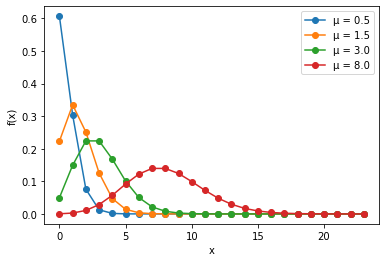

In [83]:
# visualizing Poisson
mu_params = [0.5, 1.5, 3, 8]
x = np.arange(0, max(mu_params) * 3)
for mu in mu_params:
    y = stats.poisson(mu).pmf(x)
    plt.plot(x, y, 'o-', label = f'μ = {mu:3.1f}')
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')